In [ ]:
import math
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.sequence import TimeseriesGenerator


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = yf.download('XLP', start='2018-11-30', end='2022-12-01')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-11-30,55.889999,56.400002,55.750000,56.259998,50.172440,16551900
2018-12-03,56.459999,56.459999,55.730000,56.310001,50.217030,20855900
2018-12-04,56.410000,56.619999,55.330002,55.360001,49.369823,27634900
2018-12-06,55.180000,55.439999,54.250000,55.419998,49.423332,32514000
2018-12-07,55.369999,55.570000,54.480000,54.720001,48.799068,23139500
...,...,...,...,...,...,...
2022-11-23,76.000000,76.349998,75.900002,76.199997,75.657455,6286400
2022-11-25,76.300003,76.309998,76.099998,76.250000,75.707100,2978000
2022-11-28,75.970001,76.379997,75.849998,75.959999,75.419167,8698300


Text(0, 0.5, 'Close Prices ($)')

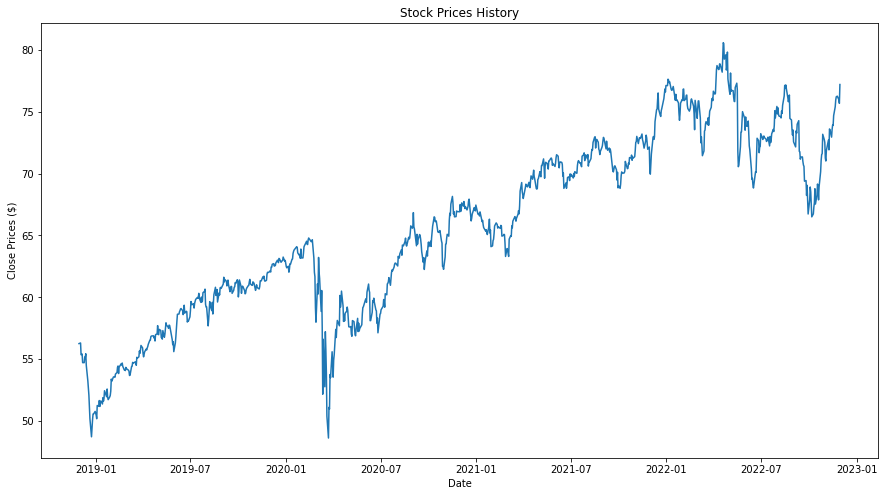

In [ ]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(df['Close'])
plt.xlabel('Date')

# Plotting the Y Label
plt.ylabel('Close Prices ($)')

In [ ]:
window_size = 252

In [ ]:
close_prices = df['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [ ]:


test_data = scaled_data[training_data_len- window_size: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(window_size, len(test_data)):
  x_test.append(test_data[i-window_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM


In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 252, 100)          40800     
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dense_6 (Dense)             (None, 25)                2525      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)


Epoch 1/3
554/554 [==============================] - 23s 36ms/step - loss: 0.0049
Epoch 2/3
554/554 [==============================] - 13s 24ms/step - loss: 0.0021
Epoch 3/3
554/554 [==============================] - 16s 28ms/step - loss: 0.0016


In [ ]:
x_train.shape

(554, 252, 1)

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

7/7 [==============================] - 1s 13ms/step


0.4251742386699316

<ipython-input-69-d4202c9d2279>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


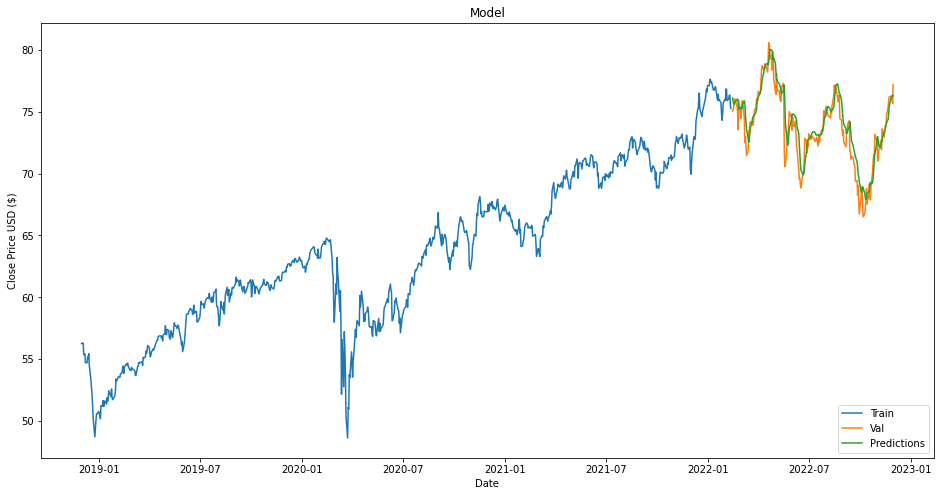

In [ ]:
data = df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
days = [1, 4, 21, 61, 124]
time = ['1 day', '1 week', '1 month', '3 months', '6 months', '1 year']


def percent_error(actual_price, predicted_price):
  return round((abs(actual_price - predicted_price) / predicted_price * 100), 2)


for i in range(5):

  predicted_price = predictions[days[i]][0]
  actual_price = y_test[days[i]]

  print(f'After {time[i]}')
  predicted_price = round(float(predicted_price), 2)
  actual_price = round(float(actual_price), 2)


  print(f'The Actual Price: {actual_price}')
  print(f'The Predicted Price: {predicted_price}')


  print(f'Percent Error: {percent_error(actual_price, predicted_price)}\n')

  percent_errors = 0

for i in range(len(predictions)):
  predicted_price = predictions[i][0]
  actual_price = y_test[i]

  predicted_price = float(predicted_price)
  actual_price = float(actual_price)

  percent_errors += percent_error(actual_price, predicted_price)

print(f"Average Percent Errors = {round (percent_errors / len(predictions),2)}")

print(f'RMSE = {round(float(rmse),2)}')

After 1 day
The Actual Price: 75.17
The Predicted Price: 75.81
Percent Error: 0.84

After 1 week
The Actual Price: 76.03
The Predicted Price: 75.76
Percent Error: 0.36

After 1 month
The Actual Price: 73.51
The Predicted Price: 72.79
Percent Error: 0.99

After 3 months
The Actual Price: 75.81
The Predicted Price: 76.67
Percent Error: 1.12

After 6 months
The Actual Price: 75.51
The Predicted Price: 75.12
Percent Error: 0.52

Average Percent Errors = 1.23
RMSE = 0.43


In [ ]:
predictions

array([[76.10828 ],
       [75.80915 ],
       [75.633385],
       [75.5854  ],
       [75.75824 ],
       [75.98941 ],
       [76.008575],
       [75.79127 ],
       [75.20042 ],
       [75.34163 ],
       [75.35505 ],
       [75.218414],
       [75.30345 ],
       [75.598206],
       [75.87432 ],
       [75.67598 ],
       [74.831535],
       [74.176636],
       [73.5565  ],
       [72.8946  ],
       [72.521904],
       [72.79363 ],
       [73.21039 ],
       [73.71194 ],
       [74.14909 ],
       [74.375244],
       [74.62516 ],
       [74.62982 ],
       [74.702736],
       [74.93846 ],
       [75.23621 ],
       [75.6552  ],
       [75.999405],
       [76.16963 ],
       [76.4532  ],
       [76.60988 ],
       [76.703514],
       [77.02562 ],
       [77.58543 ],
       [78.1464  ],
       [78.45334 ],
       [78.603   ],
       [78.78441 ],
       [78.90823 ],
       [78.78856 ],
       [78.98152 ],
       [79.546394],
       [80.03277 ],
       [79.99274 ],
       [79.92303 ],


In [ ]:
print(x_test.shape)
predictions.shape

(201, 252, 1)


(201, 1)

In [ ]:
print(training_data_len - window_size)
print(training_data_len)

554
806
